### code to upload files which are not folders in colab

In [ ]:
from google.colab import files
upload=files.upload()

Saving pepsi.jpg to pepsi.jpg


### code to upload folder

In [1]:
from google.colab import drive#drive means google drive
drive.mount('/content/drive/')#this is the default directory of google drive
#Go to URL in browser is to make sure I'm the owner of the account
#After this section the drive files has been upload

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [2]:
!ln -s "/content/drive/My Drive/Colab Notebooks/" "/content/"
#Someone on the internet says move the folder into another path 
#which is not "drive" can speed up the code

# Fully Convolutional Networks for semantic segmentation

In an image for the semantic segmentation, each pixcel is labeled with the class of its enclosing object. The semantic segmentation problem requires to make a classification at every pixel.

First, download data from:

https://drive.google.com/file/d/0B0d9ZiqAgFkiOHR1NTJhWVJMNEU/view

and save the downloaded data folder in the current directory.

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


0016E5_05430.png
seg.shape=(360, 480, 3), img_is.shape=(360, 480, 3)
minimum seg = 0, maximum seg = 11, Total number of segmentation classes = 12


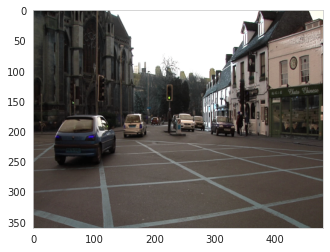

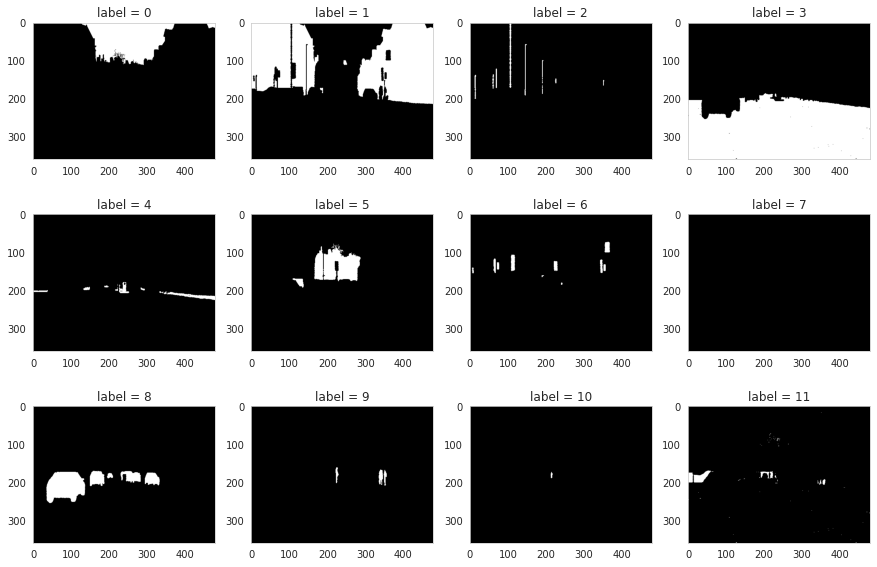

In [3]:
import cv2, os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid", {'axes.grid' : False})
# enter your path here
dir_seg = "/content/Colab Notebooks/dataset1/annotations_prepped_train/"# annotations_prepped_train   Don't forget to write "." in front of /
dir_img = "/content/Colab Notebooks/dataset1/images_prepped_train/"# images_prepped_train

ldseg = np.array(os.listdir(dir_seg))

## pick the first image file
fnm = ldseg[0]
print(fnm)

## read in the original image and segmentation labels
## Read first image from annotations_prepped_train and images_prepped_train with path "dir_seg +"/"+ fnm"
#if using imread here, seg will be 2-dimension instead of 3-dimension
seg = cv2.imread(dir_seg  +"/"+ fnm ) # image from annotations_prepped_train (360, 480, 3)
img_is = cv2.imread(dir_img  +"/"+ fnm )# image from images_prepped_train
print("seg.shape={}, img_is.shape={}".format(seg.shape,img_is.shape))

## Check the number of labels
mi, ma = np.min(seg), np.max(seg)
n_classes = ma-mi+1
print("minimum seg = {}, maximum seg = {}, Total number of segmentation classes = {}".format(mi,ma, n_classes))

# Plot original image from images_prepped_train image:
plt.imshow(img_is)
# Plot all class from annotations_prepped_train image:
fig = plt.figure(figsize=(15,10))
for k in range(mi,ma+1):
    ax = fig.add_subplot(3,n_classes/3,k+1)
    ax.imshow((seg == k)*1.0)
    ax.set_title("label = {}".format(k))

plt.show()

From the first section, we can see there are 12 segmentation classes and the image is from a driving car.

Assign color to annotations_prepped_train image

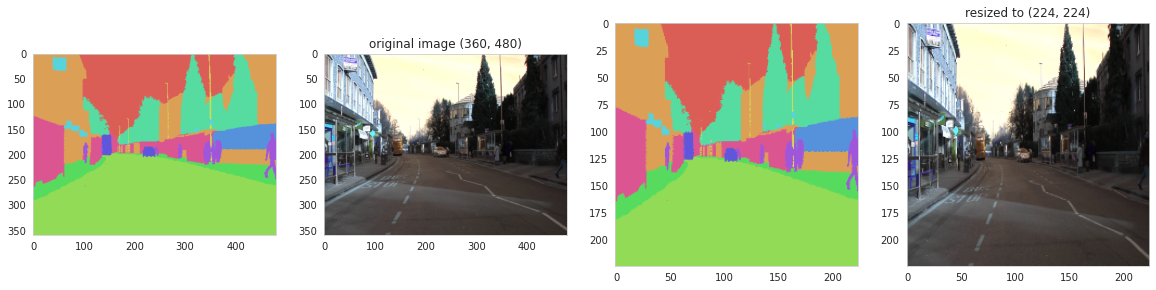

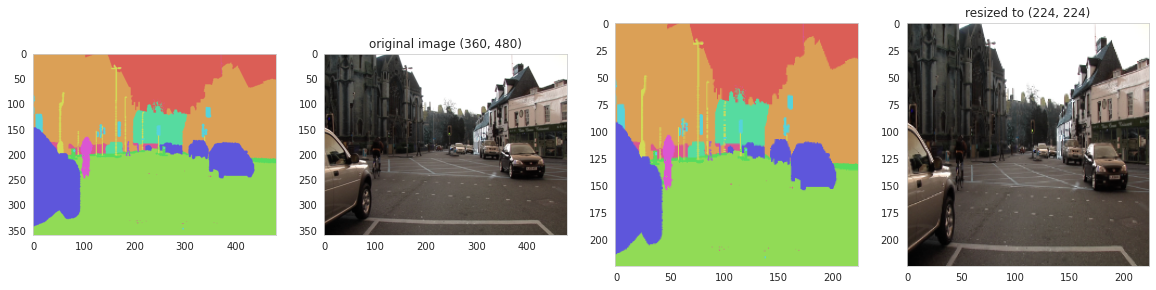

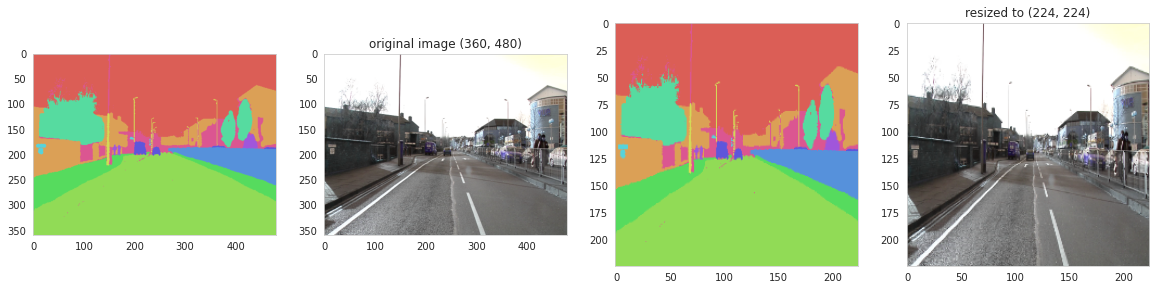

In [4]:
import random
def give_color_to_seg_img(seg,n_classes):
    seg_img=np.zeros(seg.shape) #note:seg is a 3_dimension image!!
    for i in range(n_classes):
        indexh=np.where(seg==i)[0]
        indexw=np.where(seg==i)[1]
        seg_img[indexh,indexw,:]= sns.color_palette("hls", n_classes)[i]
    return(seg_img)

input_height , input_width = 224 , 224
output_height , output_width = 224 , 224


ldseg = np.array(os.listdir(dir_seg))
for fnm in ldseg[np.random.choice(len(ldseg),3,replace=False)]:
    #np.random.choice() choose random number from [0,len(ldseg)), returns to a array. 3 is size. False means cannot choose repeated numbers
    # randomly select on the training image
    fnm = fnm.split(".")[0]#get the name of original image and discard ".png"
    seg = cv2.imread(dir_seg  +"/"+ fnm + ".png") # (360, 480, 3)
    img_is = cv2.imread(dir_img  +"/"+ fnm + ".png")
    # assign color to its annotations_prepped_train image
    seg_img = give_color_to_seg_img(seg,n_classes)

    fig = plt.figure(figsize=(20,40))
    ax = fig.add_subplot(1,4,1)
    ax.imshow(seg_img)
    
    ax = fig.add_subplot(1,4,2)
    ax.imshow(img_is/255.0)
    ax.set_title("original image {}".format(img_is.shape[:2]))
    
    ax = fig.add_subplot(1,4,3)
    ax.imshow(cv2.resize(seg_img,(output_height , output_width)))
    
    ax = fig.add_subplot(1,4,4)
    ax.imshow(cv2.resize(img_is,(output_height , output_width))/255.0)
    ax.set_title("resized to {}".format((output_height , output_width)))
    plt.show()

To simplify the problem, I will reshape all the images to the same size: (224,224). 

Since this is the image shape used in VGG and FCN model in this blog uses a network that takes advantage of VGG structure. The FCN model becomes easier to explain when the image shape is (224,224).

In [ ]:
def getImageArr( path , width , height ):
        img = cv2.imread(path, 1)
        # 1 means input a colored images, while 0 or 2 represent grayscale image. other numbers will get the colored output
        img = np.float32(cv2.resize(img, ( width , height ))) / 127.5 - 1
        return img

def getSegmentationArr( path , nClasses ,  width , height  ):

    seg_labels = np.zeros((  height , width  , nClasses ))
    img = cv2.imread(path, 1)
    img = cv2.resize(img, ( width , height ))
    img = img[:, : , 0]

    for c in range(nClasses):    
        seg_labels[: , : , c ] = (img == c ).astype(int)
    ##seg_labels = np.reshape(seg_labels, ( width*height,nClasses  ))
    return seg_labels

  
images = os.listdir(dir_img)
images.sort()#sort it
segmentations  = os.listdir(dir_seg)
segmentations.sort()
    
X = []
Y = []
for im , seg in zip(images,segmentations) :#zip is generator and returns to list[(),(),......],im and seg here are the names of images
    X.append( getImageArr(dir_img +"/"+ im , input_width , input_height )  )
    Y.append( getSegmentationArr( dir_seg +"/"+ seg , n_classes , output_width , output_height )  )

X, Y = np.array(X) , np.array(Y)
print(X.shape,Y.shape)
#X,Y are arrays. There shapes are down below. 367 images in total; So X,Y contains all the trained original images and annotation images

(367, 224, 224, 3) (367, 224, 224, 12)


Import Keras and Tensorflow to develop deep learning FCN models

In [5]:
## Import usual libraries
import tensorflow as tf
from tensorflow.python.keras.backend import set_session#this sentence is changed 
#or it will raise errors : No module named 'keras.backend.tensorflow_backend'; 'keras.backend' is not a package
import keras, sys, time, warnings
from tensorflow.python.keras.models import *#these 2 sentence are changed to make Input() works later
from tensorflow.python.keras.layers import *

tf.compat.v1.disable_eager_execution()

import pandas as pd 
warnings.filterwarnings("ignore")

###############################################
  
# check python, keras, and tensorflow version
print("python {}".format(sys.version))
print("keras version {}".format(keras.__version__)); del keras# del delete the variables
print("tensorflow version {}".format(tf.__version__))

python 3.6.9 (default, Jul 17 2020, 12:50:27) 
[GCC 8.4.0]
keras version 2.4.3
tensorflow version 2.3.0


# From classifier to dense FCN
The recent successful deep learning models such as VGG are originally designed for classification task. The network stacks convolution layers together with down-sampling layers, such as max-pooling, and then finally stacks fully connected layers. Appending a fully connected layer enables the network to learn something using global information where the spatial arrangement of the input falls away.

# Fully convolutional network
For the segmentation task, however, spatial infomation should be stored to make a pixel-wise classification. FCN allows this by making all the layers of VGG to convolutional layers.

Fully convolutional indicates that the neural network is composed of convolutional layers without any fully-connected layers usually found at the end of the network. Fully Convolutional Networks for Semantic Segmentation motivates the use of fully convolutional networks by "convolutionalizing" popular CNN architectures e.g. VGG can also be viewed as FCN.

The following method is FCN8 from Fully Convolutional Networks for Semantic Segmentation. It deplicates VGG16 net by discarding the final classifier layer and convert all fully connected layers to convolutions. Output image size is (output_height, output_width) = (224,224).

# Upsampling
The upsampling layer brings low resolution image to high resolution. There are various upsamping methods. This presentation gives a good overview. For example, one may double the image resolution by duplicating each pixcel twice. This is so-called nearest neighbor approach and implemented in Keras's UpSampling2D.

These upsampling layers do not have weights/parameters so the model is not flexible. Instead, FCN8 uses upsampling procedure called backwards convolusion (sometimes called deconvolution) with output stride. This method simply reverses the forward and backward passes of convolution and implemented in Keras's Conv2DTranspose.

In FCN8, the upsampling layer is followed by several skip connections. See details at Fully Convolutional Networks for Semantic Segmentation.

Downloaded VGG16 weights from fchollet's Github:  
https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5

This is a massive .h5 file (57MB).

In [6]:
# location of weights
VGG_Weights_path = "/content/Colab Notebooks/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5" 
FCN16_Weights_path="/content/Colab Notebooks/model16.h5" 

## FCN16
### code down below is about FCN16

In [7]:
def FCN16( nClasses ,  input_height=224, input_width=224):
    ## input_height and width must be devisible by 32 because maxpooling with filter size = (2,2) is operated 5 times,  
    ## which makes the input_height and width 2^5 = 32 times smaller
    assert input_height%32 == 0
    assert input_width%32 == 0
    IMAGE_ORDERING =  "channels_last" 
    img_input = Input(shape=(input_height,input_width, 3)) ## Assume 224,224,3
    #actually the shape of tf.python.keras.layers.Input is [batch_size,224,224,3], batch_size is None here.
    
    # Block 1  default: using bias
    x1 = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1', data_format=IMAGE_ORDERING )(img_input)
    x1 = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2', data_format=IMAGE_ORDERING )(x1)
    x1 = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool', data_format=IMAGE_ORDERING )(x1)

    # Block 2
    x2 = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1', data_format=IMAGE_ORDERING )(x1)
    x2 = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2', data_format=IMAGE_ORDERING )(x2)
    x2 = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool', data_format=IMAGE_ORDERING )(x2)
    # Block 3
    x3 = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1', data_format=IMAGE_ORDERING )(x2)
    x3 = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2', data_format=IMAGE_ORDERING )(x3)
    x3 = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3', data_format=IMAGE_ORDERING )(x3)
    x3 = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool', data_format=IMAGE_ORDERING )(x3)
    # Block 4
    x4 = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1', data_format=IMAGE_ORDERING )(x3)
    x4 = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2', data_format=IMAGE_ORDERING )(x4)
    x4 = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3', data_format=IMAGE_ORDERING )(x4)
    x4 = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool', data_format=IMAGE_ORDERING )(x4)
    # Block 5
    x5 = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1', data_format=IMAGE_ORDERING )(x4)
    x5 = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2', data_format=IMAGE_ORDERING )(x5)
    x5 = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3', data_format=IMAGE_ORDERING )(x5)
    x5 = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool', data_format=IMAGE_ORDERING )(x5)#now x.shape is (batch_size,7,7,512)
    
    n = 4096
    
    x6 = Conv2D(n, (3, 3), activation='relu', padding='same', name='conv6',data_format=IMAGE_ORDERING )(x5)
    x7 = Conv2D(n_classes, (3, 3), activation='relu', padding='same',name='conv7', data_format=IMAGE_ORDERING )(x6)
    #now conv7.shape is (batchsize,7,7,4096)
    ## 2 times upsampling for cov7
    upsampled_conv7=UpSampling2D(size=(2,2),interpolation='bilinear')(x7)#shape [batchsize,14,14,12]
    pool4_tem=Conv2D(n_classes, (3, 3), activation='relu', padding='same', name='pool4_tem', data_format=IMAGE_ORDERING )(x4)
    #(batch_size,14,14,12)
    
    #combine the upsampling and softmax
    fuse=Add()([upsampled_conv7,pool4_tem])
    upsample_16=UpSampling2D(size=(16,16),interpolation='bilinear')(fuse)
    prediction=Softmax(axis=-1)(upsample_16)
    #output image shape
    # create model and load weight
    model=Model(inputs=img_input,outputs=prediction)
    model.load_weights(FCN16_Weights_path, by_name=True)
    #don't load_weights or the max accuracy will decline


    return model
model16 = FCN16(nClasses     = n_classes,  
             input_height = 224, 
             input_width  = 224)


model16.summary()


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
_______________________________________________________________________________________

Split between training and testing data

In [ ]:
from sklearn.utils import shuffle
train_rate = 0.85
index_train = np.random.choice(X.shape[0],int(X.shape[0]*train_rate),replace=False)#array which has "number of images*train rate" elements
index_test  = list(set(range(X.shape[0])) - set(index_train))#return to a list containing all the test index
                            
X, Y = shuffle(X,Y)
X_train, y_train = X[index_train],Y[index_train]
X_test, y_test = X[index_test],Y[index_test]
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(311, 224, 224, 3) (311, 224, 224, 12)
(56, 224, 224, 3) (56, 224, 224, 12)


# Train the model
##I trained 150 epochs, each one spends 10 seconds

In [ ]:
from tensorflow.python.keras import optimizers# keras is not tensorflow.python.keras. This sentence should be the same as the one before


# Training data
sgd = optimizers.SGD(lr=1E-2, decay=5**(-4), momentum=0.9, nesterov=True)
model16.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

hist1 = model16.fit(X_train,y_train,
                  validation_data=(X_test,y_test),
                  batch_size=32,epochs=150,verbose=2)#this sentence feed data to the model,
                                                   #the sentences before it just create the model with specific dimension and shape(structure)
    #default batch size=32

Train on 311 samples, validate on 56 samples
Epoch 1/150
311/311 - 4s - loss: 2.4617 - accuracy: 0.2822 - val_loss: 2.4153 - val_accuracy: 0.3258
Epoch 2/150
311/311 - 3s - loss: 2.3537 - accuracy: 0.3465 - val_loss: 2.2444 - val_accuracy: 0.3700
Epoch 3/150
311/311 - 3s - loss: 1.9655 - accuracy: 0.4532 - val_loss: 1.5641 - val_accuracy: 0.5777
Epoch 4/150
311/311 - 3s - loss: 1.3935 - accuracy: 0.5884 - val_loss: 1.2335 - val_accuracy: 0.6365
Epoch 5/150
311/311 - 3s - loss: 1.2018 - accuracy: 0.6334 - val_loss: 1.1480 - val_accuracy: 0.6443
Epoch 6/150
311/311 - 3s - loss: 1.1246 - accuracy: 0.6509 - val_loss: 1.0971 - val_accuracy: 0.6562
Epoch 7/150
311/311 - 3s - loss: 1.0888 - accuracy: 0.6573 - val_loss: 1.0712 - val_accuracy: 0.6648
Epoch 8/150
311/311 - 3s - loss: 1.0585 - accuracy: 0.6681 - val_loss: 1.0097 - val_accuracy: 0.6804
Epoch 9/150
311/311 - 3s - loss: 1.0434 - accuracy: 0.6636 - val_loss: 1.0021 - val_accuracy: 0.6870
Epoch 10/150
311/311 - 3s - loss: 1.0105 - acc

In [ ]:
hist2 = model16.fit(X_train,y_train,
                  validation_data=(X_test,y_test),
                  batch_size=32,epochs=150,verbose=2)

Train on 311 samples, validate on 56 samples
Epoch 1/150
311/311 - 3s - loss: 0.4104 - accuracy: 0.8820 - val_loss: 0.5532 - val_accuracy: 0.8411
Epoch 2/150
311/311 - 3s - loss: 0.4287 - accuracy: 0.8753 - val_loss: 0.5386 - val_accuracy: 0.8441
Epoch 3/150
311/311 - 3s - loss: 0.4098 - accuracy: 0.8818 - val_loss: 0.5406 - val_accuracy: 0.8440
Epoch 4/150
311/311 - 3s - loss: 0.4126 - accuracy: 0.8802 - val_loss: 0.5660 - val_accuracy: 0.8354
Epoch 5/150
311/311 - 3s - loss: 0.4143 - accuracy: 0.8805 - val_loss: 0.5401 - val_accuracy: 0.8436
Epoch 6/150
311/311 - 3s - loss: 0.4203 - accuracy: 0.8772 - val_loss: 0.5622 - val_accuracy: 0.8379
Epoch 7/150
311/311 - 3s - loss: 0.4096 - accuracy: 0.8816 - val_loss: 0.5531 - val_accuracy: 0.8389
Epoch 8/150
311/311 - 3s - loss: 0.4100 - accuracy: 0.8807 - val_loss: 0.5403 - val_accuracy: 0.8440
Epoch 9/150
311/311 - 3s - loss: 0.4171 - accuracy: 0.8784 - val_loss: 0.5837 - val_accuracy: 0.8306
Epoch 10/150
311/311 - 3s - loss: 0.4108 - acc

In [ ]:
#save the weights
model16.save("model16.h5")
print("model saved")

model saved


# test: prediction and visual 

In [8]:
#get test part of dataset

def getImageArr( path , width , height ):
        img = cv2.imread(path, 1)
        # 1 means input a colored images, while 0 or 2 represent grayscale image. other numbers will get the colored output
        img = np.float32(cv2.resize(img, ( width , height ))) / 127.5 - 1
        return img

def getSegmentationArr( path , nClasses ,  width , height  ):

    seg_labels = np.zeros((  height , width  , nClasses ))
    img = cv2.imread(path, 1)
    img = cv2.resize(img, ( width , height ))
    img = img[:, : , 0]

    for c in range(nClasses):    
        seg_labels[: , : , c ] = (img == c ).astype(int)
    ##seg_labels = np.reshape(seg_labels, ( width*height,nClasses  ))
    return seg_labels

dir_test_seg = "/content/Colab Notebooks/dataset1/annotations_prepped_test/"# annotations_prepped_train   Don't forget to write "." in front of /
dir_test_img = "/content/Colab Notebooks/dataset1/images_prepped_test/"# images_prepped_train
  
test_images = os.listdir(dir_test_img)
test_images.sort()#sort it
test_segmentations  = os.listdir(dir_test_seg)
test_segmentations.sort()
    
imgs = []
segs = []
input_width=224
input_height=224
output_width=224
output_height=224

for im , seg in zip(test_images,test_segmentations) :#zip is generator and returns to list[(),(),......],im and seg here are the names of images
    imgs.append( getImageArr(dir_test_img +"/"+ im , input_width , input_height )  )
    segs.append( getSegmentationArr( dir_test_seg +"/"+ seg , n_classes , output_width , output_height )  )

imgs, segs = np.array(imgs) , np.array(segs)
print(imgs.shape,segs.shape)

(101, 224, 224, 3) (101, 224, 224, 12)


In [9]:
#make predictions by keras.Model.predicit
predictions=model16.predict(imgs, batch_size=None)
#print(predictions.shape) -> output:(101,224,224,12)

#make it to be 1 or 0
predictions=(predictions+0.5).astype(int)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


In [10]:
#functions for visualize
import numpy as np
def give_color_to_seg_img(seg,n_classes):
    seg_img=np.zeros(seg.shape) #note:seg is a 3_dimension image!!
    for i in range(n_classes):
        indexh=np.where(seg==i)[0]
        indexw=np.where(seg==i)[1]
        seg_img[indexh,indexw,:]= sns.color_palette("hls", n_classes)[i]
    return(seg_img)
def visualize(output):#a function convert 12-dimension to 3-dimension; values changed from 0/1 to 0-11
    img=np.zeros((224,224,3))
    for i in range (224):
        for j in range(224):
            index=np.where(output[i,j,:]==np.max(output[i,j,:]))[0][0]
            img[i,j,:]=index
    seg_img = give_color_to_seg_img(img,n_classes).astype(np.float)#image should be 3-dimension input
    plt.imshow(seg_img)
def choose_a_images_to_compare(num):
    
    plt.imshow(((imgs[num]+1)*127.5).astype(np.int32))
    plt.title(str(num+1)+'th image')
    plt.show()

    #annotations_prepped_test
    plt.subplot(1,2,1)
    visualize(segs[num])
    plt.title(str(num+1)+'th ground truth')
    plt.subplot(1,2,2)
    visualize(predictions[num])
    plt.title(str(num+1)+'th segmentation')
    plt.show()

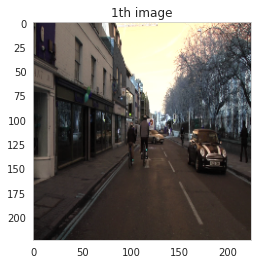

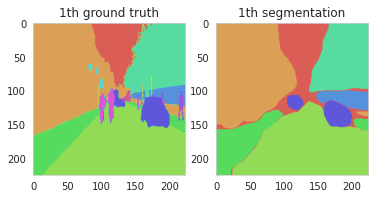

In [11]:
#call the function
choose_a_images_to_compare(0)

#intersection = np.logical_and(segs, predictions)
#union = np.logical_or(segs, predictions)
#iou_score = np.sum(intersection) / np.sum(union)
#print('mIoU for all test images',iou_score)


#Doctor's metric to test

In [12]:
#convert predictions to 3-d type
def convert_12d_to_3d(output):
  img=np.zeros((224,224,3))
  for i in range (224):
      for j in range(224):
          index=np.where(output[i,j,:]==np.max(output[i,j,:]))[0][0]
          img[i,j,:]=index
  return img
def convert_12d_dataset_to_3d(predictions):
  predictions_tem=np.zeros((predictions.shape[0],predictions.shape[1],predictions.shape[2],3))
  for i in range(predictions.shape[0]):
    predictions_tem[i]=convert_12d_to_3d(predictions[i])
  return predictions_tem

#predictions_tem is 3-d type of predictions, ranging from 0 to 11

In [13]:
Yi=convert_12d_dataset_to_3d(segs)
y_predi=convert_12d_dataset_to_3d(predictions)

In [14]:
print('Yi.shape:',Yi.shape)
print('y_predi.shape:',y_predi.shape)

Yi.shape: (101, 224, 224, 3)
y_predi.shape: (101, 224, 224, 3)


In [15]:
def IoU(Yi,y_predi):
    ## mean Intersection over Union
    ## Mean IoU = TP/(FN + TP + FP)

    IoUs = []
    Nclass = int(np.max(Yi)) + 1
    for c in range(Nclass):
        TP = np.sum( (Yi == c)&(y_predi==c) )
        FP = np.sum( (Yi != c)&(y_predi==c) )
        FN = np.sum( (Yi == c)&(y_predi != c)) 
        IoU = TP/float(TP + FP + FN)
        print("class {:02.0f}: #TP={:6.0f}, #FP={:6.0f}, #FN={:5.0f}, IoU={:4.3f}".format(c,TP,FP,FN,IoU))
        IoUs.append(IoU)
    mIoU = np.mean(IoUs)
    print("_________________")
    print("Mean IoU: {:4.3f}".format(mIoU))
    
IoU(Yi,y_predi)

class 00: #TP=1314855, #FP=1256856, #FN=53064, IoU=0.501
class 01: #TP=3161127, #FP=435552, #FN=750711, IoU=0.727
class 02: #TP=     0, #FP=     0, #FN=109260, IoU=0.000
class 03: #TP=4176732, #FP=212595, #FN=248325, IoU=0.901
class 04: #TP=1111665, #FP=247386, #FN=233634, IoU=0.698
class 05: #TP=2162568, #FP=174657, #FN=317067, IoU=0.815
class 06: #TP=  3681, #FP= 10653, #FN=156495, IoU=0.022
class 07: #TP=199338, #FP=175530, #FN=269871, IoU=0.309
class 08: #TP=196239, #FP=238899, #FN=85941, IoU=0.377
class 09: #TP=  2493, #FP= 10779, #FN=108102, IoU=0.021
class 10: #TP=  7986, #FP=  9192, #FN=324930, IoU=0.023
class 11: #TP= 16782, #FP= 77763, #FN=192462, IoU=0.058
_________________
Mean IoU: 0.371
